In [2019]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os
from skimage.feature import peak_local_max
import copy
from sklearn import preprocessing
from random import sample
import queue as Q

In [2020]:
def detectCornersHarris(images, filterSize = 2, sobelApertureSize = 3,harrisDetectorParam = 0.04):
    corners = []
    imagesWithCorners = []
    for image in images:
        grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        grey = np.float32(grey)

        imageWithCorners = image.copy()
        
        detectedCorners = cv2.cornerHarris(grey, filterSize, sobelApertureSize, harrisDetectorParam)
        detectedCorners = cv2.dilate(detectedCorners, None)

        imageWithCorners[detectedCorners>0.001*detectedCorners.max()] = [255, 0, 0]

        corners.append(detectedCorners)
        imagesWithCorners.append(imageWithCorners)
    return corners, imagesWithCorners
        
def displayImages(images, numCol = 2):
    aspectRatio = images[0].shape[0]/images[0].shape[1]
    plt.figure(figsize=(16/aspectRatio,16))
    numFigures = len(images)
    rowNum = numFigures//numCol + numCol

    for i in range(0,numFigures):
        plt.subplot(rowNum,numCol,i+1)
        plt.axis('off')
        plt.imshow(images[i],aspect=1)
    # plt.subplots_adjust(hspace=0.02,wspace=-0.2)
    return

def loadImages(imageDirPath):
    images = []
    for filename in sorted(glob.glob(imageDirPath + '*.jpg')):
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # scaleFactor = image.shape[1] / 600
        # width = int(image.shape[1]/scaleFactor)
        # height = int(image.shape[0]/scaleFactor)
        # image = cv2.resize(image, (width,height), cv2.INTER_AREA)
        images.append(image)
    return images


## Corner detection

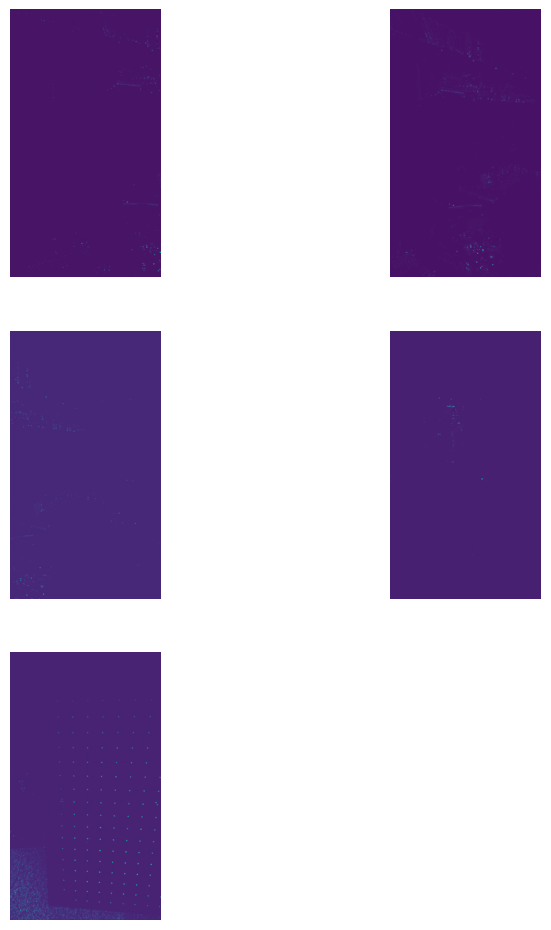

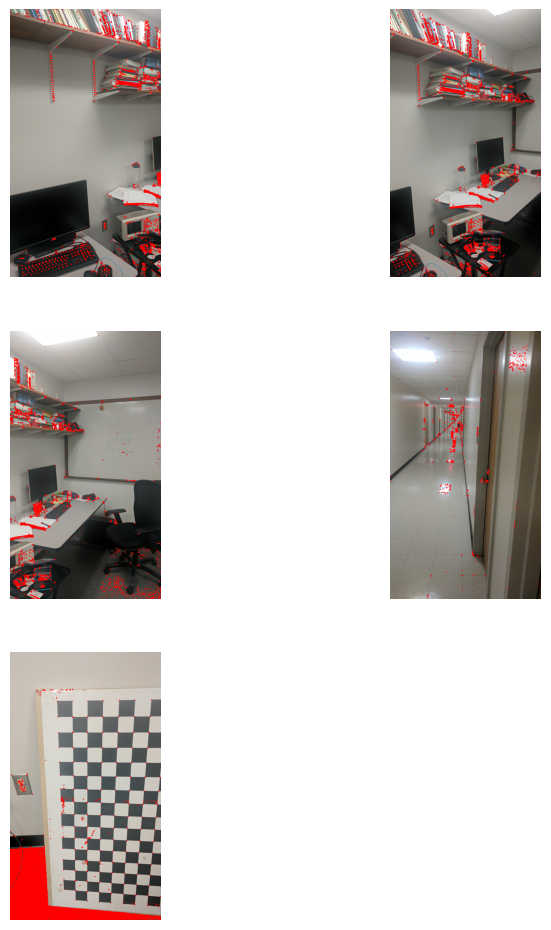

In [2021]:
dataSet = 'TestSet4'
directoryPath = os.getcwd() + '/../Data/Train/' + dataSet + '/'

rawImages = loadImages(directoryPath)
corners, imagesWithCorners = detectCornersHarris(rawImages,2,3,0.04)

# displayImages(rawImages,2)
displayImages(corners,2)
displayImages(imagesWithCorners,2)

## Adaptive Non-Maximal Suppression(ANMS)

In [2022]:
def anms(cornersImage, numBestCorners):
    localMaximaCoords = peak_local_max(cornersImage,min_distance=5,threshold_abs=0.001*cornersImage.max())
    r = np.full(len(localMaximaCoords),np.inf)
    for i in range(len(localMaximaCoords)):
        for j in range(len(localMaximaCoords)):
            xi = localMaximaCoords[i][0]
            yi = localMaximaCoords[i][1]
            xj = localMaximaCoords[j][0]
            yj = localMaximaCoords[j][1]
            if(cornersImage[xj][yj] > cornersImage[xi][yi]):
                euclideanDist = (xj - xi)*(xj - xi) + (yj - yi)*(yj - yi)
            
                if euclideanDist < r[i]:
                    r[i] = euclideanDist
    
    sorted_idx = np.argsort(r)
    sorted_idx = sorted_idx[::-1]
    return localMaximaCoords[sorted_idx[:numBestCorners]]

def anmsForImages(cornersImages, numBestCorners):
    coordsForImgs = []
    for image in cornersImages:
        coordsForImgs.append(anms(image,numBestCorners))
    return coordsForImgs

# suppressedCorners = anms(corners[0], 200)

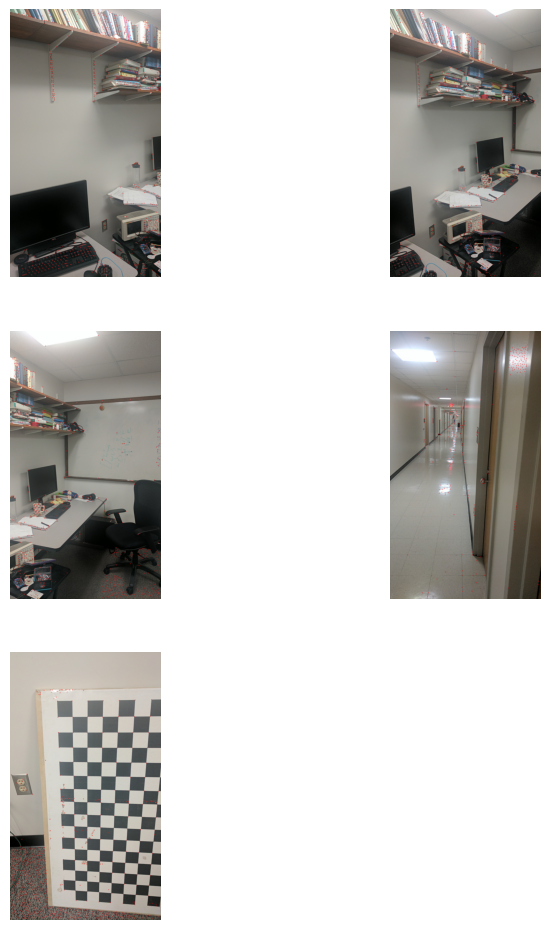

In [2023]:
imagesCorners = anmsForImages(corners, numBestCorners = 1000)
# rawImages[0][suppressedCorners[:,0]][suppressedCorners[:,1]] = [255, 0, 0]

imagesWithSupressedCorners = copy.deepcopy(rawImages)
for i in range(len(imagesCorners)):
    for pixel in imagesCorners[i]:
        imagesWithSupressedCorners[i] = cv2.circle(imagesWithSupressedCorners[i], (pixel[1],pixel[0]), radius = 2, color=(255,0,0), thickness = 1)

displayImages(imagesWithSupressedCorners,2)

## Feature Descriptor

In [2024]:
def patchAroundPixel(image,pixel,patchSize):
    patchX = pixel[1] - patchSize//2
    patchY = pixel[0] - patchSize//2
    
    patch = None
    if patchY >= 0 and patchY+patchSize < len(image) and patchX >= 0 and patchX+patchSize < len(image[0]):
        patch = image[patchY:patchY+patchSize,patchX:patchX+patchSize]
    return patch

def patchesAroundCorners(image, corners, patchSize):
    patches = []
    usableCorners = []
    for corner in corners:
        patch = patchAroundPixel(image, corner, patchSize)
        if not (patch is None):
            patches.append(patchAroundPixel(image, corner, patchSize))
            usableCorners.append(corner)
    
    return patches, usableCorners

def getImageFeaturesFromCorners(image, corners):
    greyImage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    greyImage = np.float32(greyImage)
    patches, useableCorners = patchesAroundCorners(greyImage,corners,41)
    blurredPatches = []
    for patch in patches:
        blurredPatches.append(cv2.GaussianBlur(patch,(5,5),sigmaX=1.0,sigmaY=1.0))
    downSampledPatches = []
    standardizedFeatures = []
    for patch in patches:
        downSampledPatch = cv2.resize(patch,(8,8))
        downSampledPatches.append(downSampledPatch)
        standardizedFeature = downSampledPatch.reshape((64))
        standardizedFeature = (standardizedFeature-standardizedFeature.mean())/standardizedFeature.std()
        standardizedFeatures.append(standardizedFeature)
    return standardizedFeatures, useableCorners

def getImageFeaturesAndFeatureCoords(image):
    cornersImage, _ = detectCornersHarris([image],2,3,0.04)
    corners = anms(cornersImage[0],numBestCorners=1000)
    features,useableCorners = getImageFeaturesFromCorners(image, corners)
    return features,useableCorners


imagesFeatures = []
useableImagesCorners = []
for (i,image) in enumerate(rawImages):
    features,useableCorners = getImageFeaturesFromCorners(rawImages[i], imagesCorners[i])
    imagesFeatures.append(features)
    useableImagesCorners.append(useableCorners)


## Feature Matching

In [2025]:
def SSD(feature1, feature2):
    score = 0
    for i in range(len(feature1)):
        score = score + abs(feature1[i]*feature1[i] -  feature2[i]*feature2[i])
    return score

def findFeatureMatches(featuresList1, featuresList2, acceptRatio):
    matches = []
    for i in range(len(featuresList1)):
        bestMatchScore = np.Inf
        bestMatchList2Idx = 0
        secondBestMatchScore = np.Inf
        for j in range(len(featuresList2)):
            currentScore = SSD(featuresList1[i], featuresList2[j])
            if currentScore < bestMatchScore:
                secondBestMatchScore = bestMatchScore
                bestMatchScore = currentScore
                bestMatchList2Idx = j
        if bestMatchScore/secondBestMatchScore < acceptRatio:
            matches.append([i,bestMatchList2Idx])
    return matches

def drawMatchs(img1,img2,img1FeaturePoints, img2FeaturePoints, matches):
    emptyImage = np.zeros((img2.shape[0],img1.shape[1],3), dtype=np.uint8)
    matchImage = np.concatenate((img2,emptyImage), axis=1)
    matchImage[0:img1.shape[0],img2.shape[1]:img2.shape[1]+img1.shape[1],...] = img1
    img1FeaturePoints = img1FeaturePoints + np.array([0,len(img2[0])])
    for match in matches:
        leftPoint = [img2FeaturePoints[match[1]][1],img2FeaturePoints[match[1]][0]]
        rightPoint = [img1FeaturePoints[match[0]][1],img1FeaturePoints[match[0]][0]]
        matchImage = cv2.circle(matchImage, (leftPoint[0],leftPoint[1]), radius = 4, color=(255,0,0), thickness = 2)
        matchImage = cv2.circle(matchImage, (rightPoint[0],rightPoint[1]), radius = 4, color=(0,0,255), thickness = 2)
        matchImage = cv2.line(matchImage, leftPoint, rightPoint, color=(255,255,0),thickness=2)
    return matchImage
# matches10 = findFeatureMatches(standardizedImagesFeatures[1],standardizedImagesFeatures[0], 0.9)
# matches20 = findFeatureMatches(standardizedImagesFeatures[2],standardizedImagesFeatures[0], 0.9)
# keypoints1 = usableCornersForImages[0]
# keypoints2 = usableCornersForImages[1]
# keypoints3 = usableCornersForImages[2]
# matchImage10 = drawMatchs(rawImages[1], rawImages[0], keypoints2, keypoints1,matches10)
# matchImage20 = drawMatchs(rawImages[2], rawImages[0], keypoints3, keypoints1,matches20)

# plt.figure(figsize=(32,16))
# plt.imshow(matchImage10)
# plt.axis("off")
# plt.show()

# plt.figure(figsize=(32,16))
# plt.imshow(matchImage20)
# plt.axis("off")
# plt.show()

## Random Sample Concensus(RANSAC)

In [2026]:
def ransac(coords1, coords2, matches, numIters, inlierThreshold):
    coords1= np.array(coords1)
    coords1 = np.flip(coords1, axis=1)
    coords2 = np.array(coords2)
    coords2 = np.flip(coords2, axis=1)
    matches = np.array(matches)
    matchMaskBest = np.zeros(len(matches))
    hbest = np.zeros((3,3))
    largestNumInlier = 0
    for i in range(numIters):
        samplesIdx = sample(range(0,len(matches)),4)
        samples = matches[samplesIdx]
        p1 = coords1[samples[:,0]]
        # p1 = np.flip(p1, axis = 1)
        p2 = coords2[samples[:,1]]
        # p2 = np.flip(p2, axis = 1)
        h = cv2.getPerspectiveTransform(np.float32(p1),np.float32(p2))
        matchMask = np.zeros(len(matches))
        numInlier = 0
        for j,match in enumerate(matches):
            # source = np.flip(coords1[match[0]])
            # target = np.flip(coords2[match[1]])
            source = coords1[match[0]]
            target = coords2[match[1]]

            predict = np.matmul(h, np.array([source[0],source[1],1]).transpose())
            if np.linalg.norm(target-predict[:2]) < inlierThreshold:
                numInlier +=1
                matchMask[j] = 1
        if numInlier > largestNumInlier:
            largestNumInlier = numInlier
            matchMaskBest = matchMask
            hbest = h
    cleanedMatches = matches[np.where(matchMaskBest==1)]
    # cleanedCoords1 = coords1[cleanedMatches[:,0]]
    cleanedCoords1 = np.array([coords1[i] for i in cleanedMatches[:,0]])
    # cleanedCoords1 = np.flip(cleanedCoords1, axis = 1)
    # cleanedCoords2 = coords2[cleanedMatches[:,1]]
    cleanedCoords2 = np.array([coords2[i] for i in cleanedMatches[:,1]])
    # cleanedCoords2 = np.flip(cleanedCoords2, axis = 1)
    H = np.float32([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
    if largestNumInlier >= 4:
        H,_ = cv2.findHomography(np.float32(cleanedCoords1), np.float32(cleanedCoords2))
    
    image1FeatureNum = len(np.unique(cleanedCoords1,axis=0))
    image2FeatureNum = len(np.unique(cleanedCoords2,axis=0))
    featureNumRatio = image1FeatureNum/image2FeatureNum
    return H, cleanedMatches, largestNumInlier, featureNumRatio


def buildImageConnectivityMatrix(imagesFeatures,imagesCorners):
    connectivityMatrix = np.zeros((len(imagesFeatures),len(imagesFeatures),2),dtype=int)
    for i, image1features in enumerate(imagesFeatures):
        for j, image2features in enumerate(imagesFeatures):
            if(i != j):
                matches = findFeatureMatches(image1features, image2features, 0.9)
                _,_,numMatches = ransac(imagesCorners[i], imagesCorners[j], matches, 500,30)
                if numMatches >=6:
                    connectivityMatrix[i][j] = np.array([1,numMatches])
                    connectivityMatrix[j][i] = np.array([1,numMatches])
    return connectivityMatrix

def stitchOrderBasedOnConnectivity(imageConnectivityMatrix):
    # order = Q.Queue()
    # iIndex, jIndex = np.triu_indices_from(np.zeros((len(imageConnectivityMatrix),len(imageConnectivityMatrix))),k=1)
    # for i in enumerate(iIndex):
    #     for j in enumerate(jIndex):
    connections = np.zeros(len(imageConnectivityMatrix),dtype=int)
    for i, array in enumerate(imageConnectivityMatrix):
        connections[i] = np.count_nonzero(array==1)

    order = np.argsort(connections)
    order = order[::-1]
    return order


    
# imageConnectivityMatrix = buildImageConnectivityMatrix(imagesFeatures, useableImagesCorners)

# stitchOrder = stitchOrderBasedOnConnectivity(imageConnectivityMatrix)

    
# print(imageConnectivityMatrix)
# print(stitchOrder)

# H10, cleanedMatches10 = ransac(usableCornersForImages[1], usableCornersForImages[0],matches10,10000,10)
# cleanedMatchImage10 = drawMatchs(rawImages[1], rawImages[0], keypoints2, keypoints1,cleanedMatches10)

# H20, cleanedMatches20 = ransac(usableCornersForImages[2], usableCornersForImages[0],matches20,10000,10)
# cleanedMatchImage20 = drawMatchs(rawImages[2], rawImages[0], keypoints3, keypoints1,cleanedMatches20)

# plt.figure(figsize=(32,16))
# plt.imshow(cleanedMatchImage10)
# plt.axis("off")
# plt.show()

# plt.figure(figsize=(32,16))
# plt.imshow(cleanedMatchImage20)
# plt.axis("off")
# plt.show()

## Blending Images

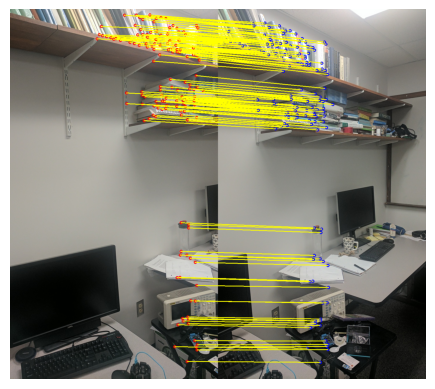

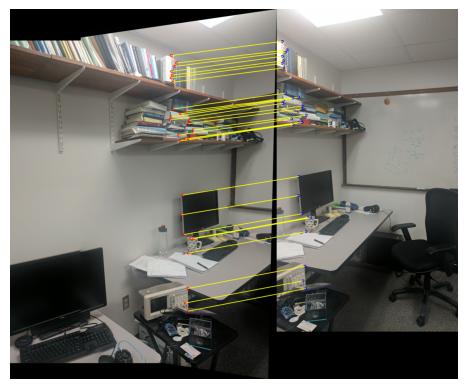

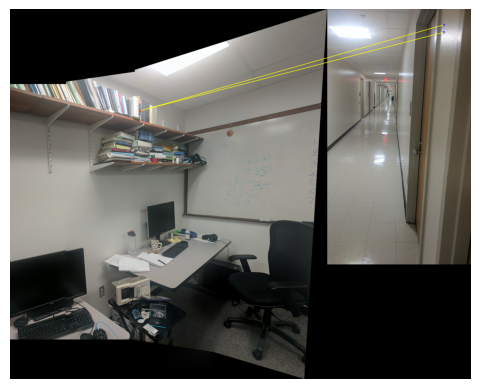

Too few feature matches found between images. Unable to stitch!!! Skipping image  3


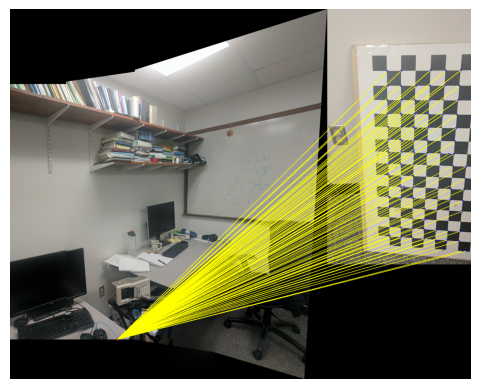

RANSAC failed! One to Many feature match situation. Unable to stitch!!! Skipping image  4


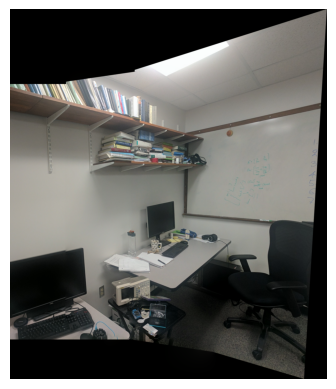

In [2027]:
def blendTwoImage(image, baseImage, homography):
    imageShape = image.shape
    baseImageShape = baseImage.shape
    homographyToChange = copy.copy(homography)
    imageCoords = np.zeros((imageShape[0],imageShape[1],3))
    imageCoordsWarped = np.zeros((imageShape[0],imageShape[1],3))
    initialImageCorners = np.float32([[0, 0],[0,imageShape[0]],[imageShape[1],imageShape[0]],[imageShape[1], 0]])
    initialBaseCorners = np.float32([[0, 0],[0,baseImageShape[0]],[baseImageShape[1],baseImageShape[0]],[baseImageShape[1], 0]])
    initialImageCorners = initialImageCorners.reshape(-1,1,2)
    initialBaseCorners = initialBaseCorners.reshape(-1,1,2)
    
    cornersWarped = cv2.perspectiveTransform(initialImageCorners, homography)
    
    xmin, ymin = cornersWarped.min(0).ravel() - 0.5
    xmax, ymax = cornersWarped.max(0).ravel() + 0.5
    
    xmin, xmax, ymin, ymax= int(xmin), int(xmax), int(ymin), int(ymax)
    basexchange = 0
    baseychange = 0
    if xmin<0:
        basexchange = abs(xmin)
    if ymin <0:
        baseychange = abs(ymin)

    hTranslateOnCanvas = np.array([[1, 0, basexchange],[0, 1, baseychange],[0, 0, 1]])
    hTranslateToZero = np.array([[1, 0, -xmin],[0, 1, -ymin],[0, 0, 1]])
    homographyToCanvas = hTranslateOnCanvas.dot(homography)
    homographyToZero = hTranslateToZero.dot(homography)
    imageWarped = cv2.warpPerspective(image, homographyToZero, (xmax-xmin, ymax-ymin))
    imageWarpedMask = np.zeros_like(imageWarped)
    for i in range(len(imageWarped)):
        for j in range(len(imageWarped[0])):
            if(imageWarped[i][j][0]>0 or imageWarped[i][j][1]>0 or imageWarped[i][j][2]>0):
                imageWarpedMask[i][j] = np.uint8([255,255,255])

    imageCornersOnCanvas = cv2.perspectiveTransform(initialImageCorners, homographyToCanvas)
    baseCornersWarped = cv2.perspectiveTransform(initialBaseCorners, hTranslateOnCanvas)

    corners = np.append(imageCornersOnCanvas, baseCornersWarped,axis=0)

    imageXmin, imageYmin = imageCornersOnCanvas.min(0).ravel() - 0.5
    imageXmax, imageYmax = imageCornersOnCanvas.max(0).ravel() + 0.5

    baseXmin, baseYmin = baseCornersWarped.min(0).ravel() - 0.5
    baseXmax, baseYmax = baseCornersWarped.max(0).ravel() + 0.5
    
    xmin, ymin = corners.min(0).ravel() - 0.5
    xmax, ymax = corners.max(0).ravel() + 0.5
    
    xmin, xmax, ymin, ymax= int(xmin), int(xmax), int(ymin), int(ymax)

    xrange = int(xmax-xmin)
    yrange = int(ymax-ymin)

    canvas = np.zeros((yrange,xrange,3),imageWarped.dtype)
    canvas[int(baseYmin):int(baseYmin)+baseImage.shape[0],int(baseXmin):int(baseXmin)+baseImage.shape[1],:] = baseImage
    for i in range(imageWarped.shape[0]):
        for j in range(imageWarped.shape[1]):
            canvasX = int(imageXmin)+j
            canvasY = int(imageYmin)+i
            if(np.array_equal(canvas[canvasY][canvasX],np.uint8([0,0,0])) and not np.array_equal(imageWarped[i][j], np.uint8([0,0,0]))):
                canvas[canvasY][canvasX] = imageWarped[i][j]

    imageCenterOnCanvas = (int(imageXmin) + imageWarped.shape[1]//2,int(imageYmin)+imageWarped.shape[0]//2)
    # canvas = cv2.circle(canvas, imageCenterOnCanvas, radius = 4, color=(255,0,0), thickness = 2)
    canvas = cv2.seamlessClone(imageWarped,canvas, imageWarpedMask, imageCenterOnCanvas, cv2.NORMAL_CLONE)
    return canvas

def stitchImages(images, stitchOrder):
    baseImage = copy.deepcopy(images[stitchOrder[0]])
    for _,imageIdx in enumerate(stitchOrder[1:]):
        stitchImage = copy.deepcopy(images[imageIdx])
        baseFeatures,baseUseableCorners = getImageFeaturesAndFeatureCoords(baseImage)
        stitchFeatures,stitchUseableCorners = getImageFeaturesAndFeatureCoords(stitchImage)
        matches = findFeatureMatches(stitchFeatures,baseFeatures,0.8)
        # matchVis = drawMatchs(images[imageIdx], baseImage, stitchUseableCorners, baseUseableCorners,matches)
        # plt.figure(figsize=(32,16))
        # plt.imshow(matchVis)
        # plt.axis("off")
        # plt.show()
        H, cleanedMatches,numMatches,featureNumRatio = ransac(stitchUseableCorners, baseUseableCorners,matches,1000,10)
        matchVis = drawMatchs(images[imageIdx], baseImage, stitchUseableCorners, baseUseableCorners,cleanedMatches)
        plt.figure()
        plt.imshow(matchVis)
        plt.axis("off")
        plt.show()
        if numMatches < 6:
            print("Too few feature matches found between images. Unable to stitch!!! Skipping image ", imageIdx)
        elif featureNumRatio < 0.5 or featureNumRatio > 2.0:
            print("RANSAC failed! One to Many feature match situation. Unable to stitch!!! Skipping image ", imageIdx)
        else:
            baseImage = blendTwoImage(stitchImage, baseImage, H)
    return baseImage

#training sets
stitchOrderSet1 = [0,2,1]
stitchOrderSet2 = [1,0,2]
stitchOrderSet3_sub1 = [4,5,6,7]
stitchOrderSet3_sub2 = [3,2,1]

#test sets
stitchOrderTestSet1 = [0,1,2,3]

stitchOrderTestSet2_sub1 = [2,1,0]
stitchOrderTestSet2_sub2 = [6,7]
stitchOrderTestSet2_sub3 = [7,3,8,4]

stitchOrderTestSet3 = [1,0,2]

stitchOrderTestSet4 = [0,1,2,3,4]





# stitchedImage_1 = stitchImages(rawImages, stitchOrderSet3_sub1)
# stitchedImage_2 = stitchImages(rawImages, stitchOrderSet3_sub2)
# stitchedImage = stitchImages([stitchedImage_1,stitchedImage_2],[1,0])
stitchedImage = stitchImages(rawImages,stitchOrderTestSet4)

plt.figure()
plt.imshow(stitchedImage)
plt.axis("off")
plt.show()
# resultFileName = os.getcwd() + '/../Data/Result/' + dataSet + '.png'
# stitchedImage = cv2.cvtColor(stitchedImage,cv2.COLOR_RGB2BGR)
# cv2.imwrite(resultFileName,stitchedImage)